<a name="table_of_contents"></a>
# Content: 

1) [The dataset](#stage_1)

* [Loading libraries and dataset.](#s_1)

2) [Top ten movies at the box office](#stage_2)

3) [Movie genre trend](#stage_3)

* [Are there any peculiarities in monthly trends for movie releases?](#s_2)

4) [Data transformation](#stage_4)

5) [The genre effect](#stage_5)

6) [Confidence intervals for regression parameters (i)](#stage_6)

7) [Confidence intervals for regression parameters (ii)](#stage_7)

8) [Confidence intervals for regression parameters (iii)](#stage_8)

9) [Should Disney make more action and adventure movies?](#stage_9)

<a name="stage_1"></a>
## 1. The dataset
[To the table of contents](#table_of_contents)
<p>Walt Disney Studios is the foundation on which The Walt Disney Company was built. The Studios has produced more than 600 films since their debut film,  Snow White and the Seven Dwarfs in 1937. While many of its films were big hits, some of them were not. In this notebook, we will explore a dataset of Disney movies and analyze what contributes to the success of Disney movies.</p>
<p>First, we will take a look at the Disney data compiled by <a href="https://data.world/kgarrett/disney-character-success-00-16">Kelly Garrett</a>. The data contains 579 Disney movies with six features: movie title, release date, genre, MPAA rating, total gross, and inflation-adjusted gross. </p>
<p>Let's load the file and see what the data looks like.</p>

<a name="s_1"></a>
### Loading libraries and dataset.
[To the table of contents](#table_of_contents)

In [1]:
! pip install missingno
! pip install seaborn==0.9.0

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import math
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
df = pd.read_csv('disney_movies_total_gross.csv')
df.head(5)

,movie_title,release_date,genre,mpaa_rating,total_gross,inflation_adjusted_gross
0,Snow White and the Seven Dwarfs,1937-12-21,Musical,G,184925485,5228953251
1,Pinocchio,1940-02-09,Adventure,G,84300000,2188229052
2,Fantasia,1940-11-13,Musical,G,83320000,2187090808
3,Song of the South,1946-11-12,Adventure,G,65000000,1078510579
4,Cinderella,1950-02-15,Drama,G,85000000,920608730


In [3]:
print(df.shape)
print('\n----------------------------')
df.info()

(579, 6)

----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   movie_title               579 non-null    object
 1   release_date              579 non-null    object
 2   genre                     562 non-null    object
 3   mpaa_rating               523 non-null    object
 4   total_gross               579 non-null    int64 
 5   inflation_adjusted_gross  579 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 27.3+ KB


In [4]:
df['release_date'] = pd.to_datetime(df['release_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   movie_title               579 non-null    object        
 1   release_date              579 non-null    datetime64[ns]
 2   genre                     562 non-null    object        
 3   mpaa_rating               523 non-null    object        
 4   total_gross               579 non-null    int64         
 5   inflation_adjusted_gross  579 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 27.3+ KB


In [5]:
df.describe()

,total_gross,inflation_adjusted_gross
count,5.790000e+02,5.790000e+02
mean,6.470179e+07,1.187625e+08
std,9.301301e+07,2.860853e+08
min,0.000000e+00,0.000000e+00
25%,1.278886e+07,2.274123e+07
50%,3.070245e+07,5.515978e+07
75%,7.570903e+07,1.192020e+08
max,9.366622e+08,5.228953e+09


<AxesSubplot:>

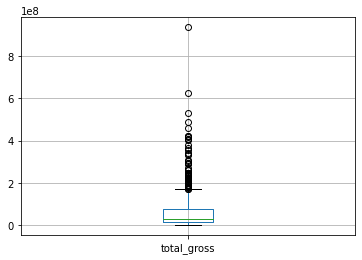

In [6]:
df.boxplot(column='total_gross')

In [7]:
print('Duplicates in the dataset :', df.duplicated().sum())
print('\nMissing values in the dataset:', df.isna().sum())

Duplicates in the dataset : 0

Missing values in the dataset: movie_title                  0
release_date                 0
genre                       17
mpaa_rating                 56
total_gross                  0
inflation_adjusted_gross     0
dtype: int64


<AxesSubplot:>

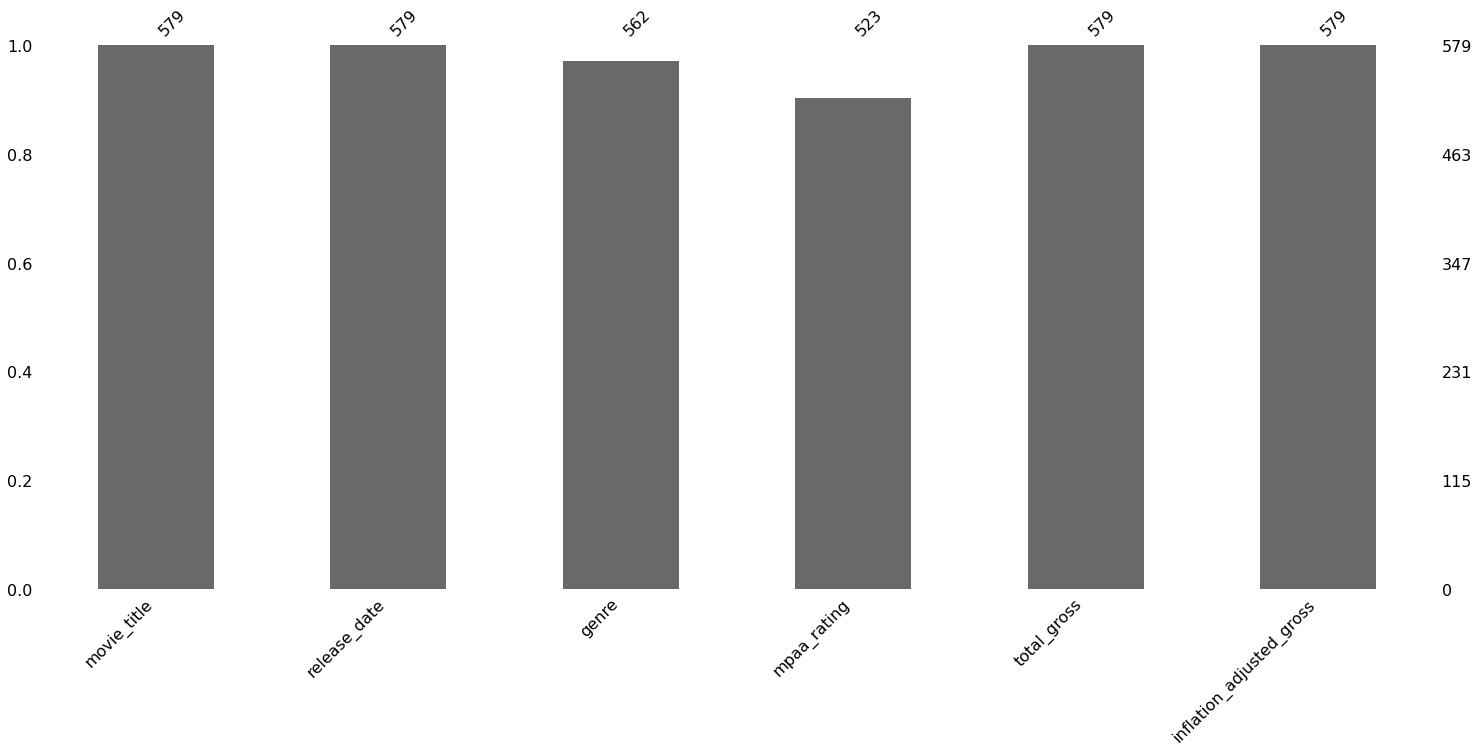

In [8]:
msno.bar(df)

In [9]:
print('Duplicates in the dataset :', df.duplicated().sum())
print('\nMissing values in the dataset:', df.isna().sum())

Duplicates in the dataset : 0

Missing values in the dataset: movie_title                  0
release_date                 0
genre                       17
mpaa_rating                 56
total_gross                  0
inflation_adjusted_gross     0
dtype: int64


In [10]:
df.isna().sum()/df.shape[0]

movie_title                 0.000000
release_date                0.000000
genre                       0.029361
mpaa_rating                 0.096718
total_gross                 0.000000
inflation_adjusted_gross    0.000000
dtype: float64

#### My notice:
The lack of data does not exceed 10%. I will not do anything with missing values. Replacing data with "No data" will create separate categories of genres, which will interfere with data visualization and further analysis of which genres need to be increased in production.

<a name="stage_1"></a>
## 2. Top ten movies at the box office
[To the table of contents](#table_of_contents)
<p>Let's started by exploring the data. We will check which are the 10 Disney movies that have earned the most at the box office. We can do this by sorting movies by their inflation-adjusted gross (we will call it adjusted gross from this point onward). </p>

In [11]:
# Sort data by the adjusted gross in descending order 
df = df.sort_values(by = 'inflation_adjusted_gross', ascending = False)
df.head(10)

,movie_title,release_date,genre,mpaa_rating,total_gross,inflation_adjusted_gross
0,Snow White and the Seven Dwarfs,1937-12-21,Musical,G,184925485,5228953251
1,Pinocchio,1940-02-09,Adventure,G,84300000,2188229052
2,Fantasia,1940-11-13,Musical,G,83320000,2187090808
8,101 Dalmatians,1961-01-25,Comedy,G,153000000,1362870985
6,Lady and the Tramp,1955-06-22,Drama,G,93600000,1236035515
3,Song of the South,1946-11-12,Adventure,G,65000000,1078510579
564,Star Wars Ep. VII: The Force Awakens,2015-12-18,Adventure,PG-13,936662225,936662225
4,Cinderella,1950-02-15,Drama,G,85000000,920608730
13,The Jungle Book,1967-10-18,Musical,Not Rated,141843000,789612346
179,The Lion King,1994-06-15,Adventure,G,422780140,761640898


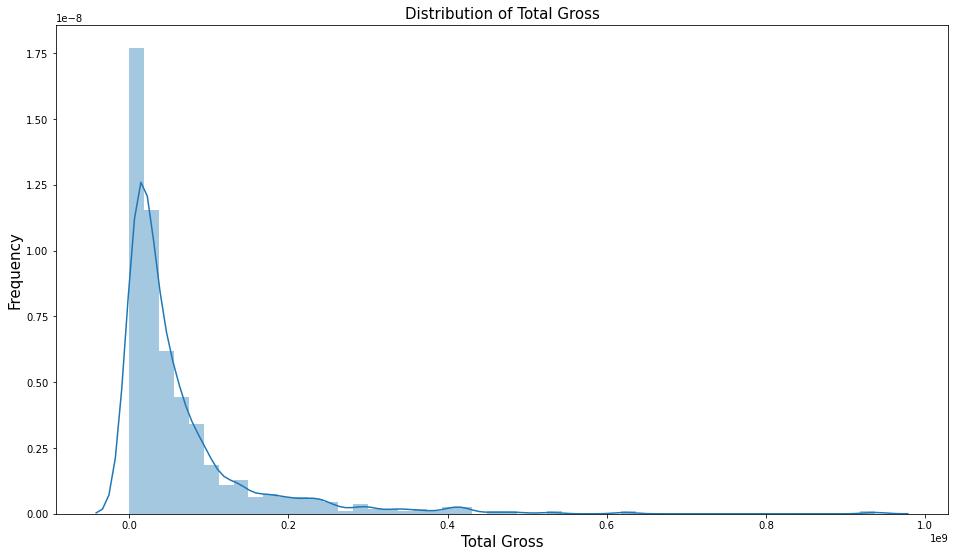

In [12]:
ax=plt.figure(figsize=(16,9))
ax=sns.distplot(df['total_gross'])
plt.title(f'Distribution of Total Gross', fontsize=15)
plt.xlabel("Total Gross", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()

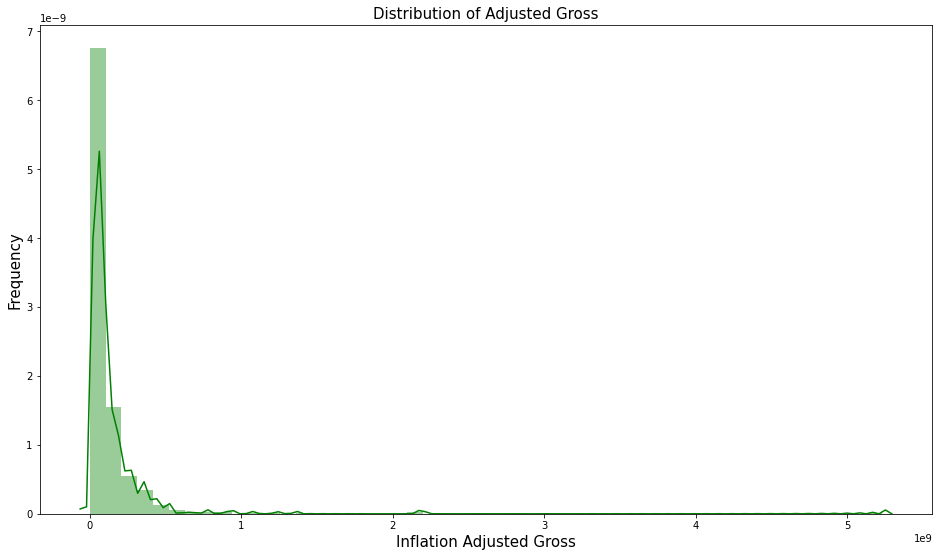

In [13]:
ax=plt.figure(figsize=(16,9))
ax=sns.distplot(df['inflation_adjusted_gross'], color='green')
plt.title(f'Distribution of Adjusted Gross', fontsize=15)
plt.xlabel("Inflation Adjusted Gross", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()

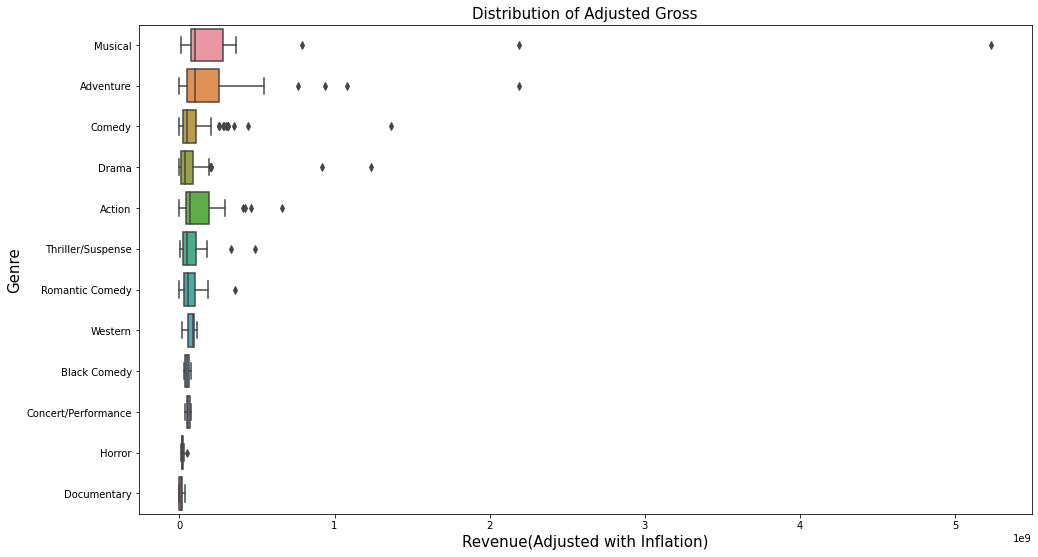

In [14]:
ax=plt.figure(figsize=(16,9))
ax=sns.boxplot(data=df, x='inflation_adjusted_gross', y='genre')
plt.title(f'Distribution of Adjusted Gross', fontsize=15)
plt.xlabel("Revenue(Adjusted with Inflation)", fontsize=15)
plt.ylabel("Genre", fontsize=15)
plt.show()

<a name="stage_3"></a>
## 3. Movie genre trend
[To the table of contents](#table_of_contents)
<p>From the top 10 movies above, it seems that some genres are more popular than others. So, we will check which genres are growing stronger in popularity. To do this, we will group movies by genre and then by year to see the adjusted gross of each genre in each year.</p>

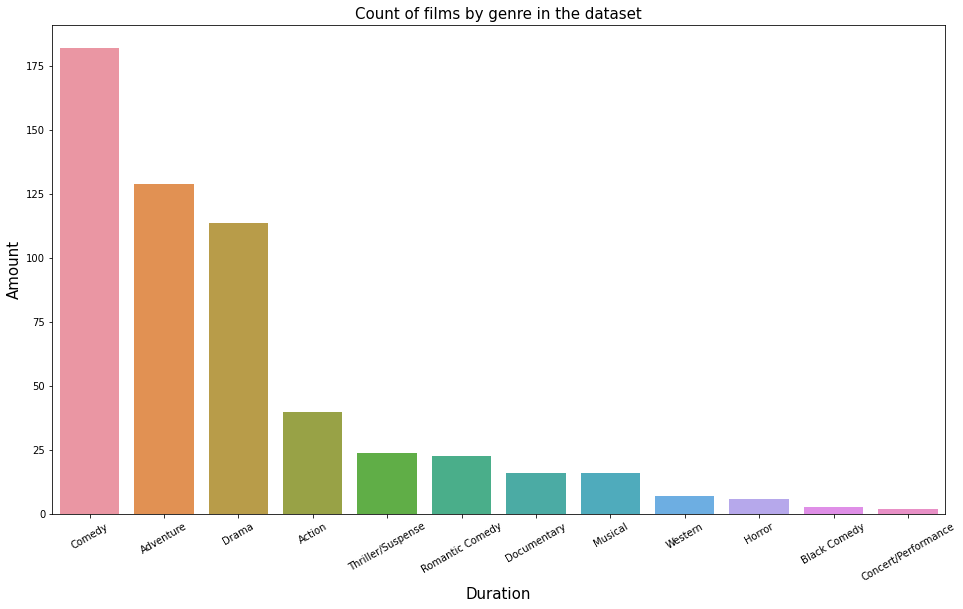

In [15]:
count_genre = df[['genre']].value_counts().reset_index().rename(columns={0:'count'})

plt.figure(figsize=(16,9))
ax=sns.barplot(x='genre', y='count', data=count_genre)
plt.title(f'Count of films by genre in the dataset', fontsize=15)
plt.xlabel("Duration", fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.ylabel("Amount", fontsize=15)
plt.show()

In [16]:
 # Extract year from release_date and store it in a new column
df['release_year'] = pd.DatetimeIndex(df['release_date']).year
df['release_month'] = pd.DatetimeIndex(df['release_date']).month

# Compute mean of adjusted gross per genre and per year
group = df.groupby(by = ['genre','release_year']).mean()

# Convert the GroupBy object to a DataFrame
genre_yearly = group.reset_index()

# Inspect genre_yearly 
genre_yearly.drop(labels=[0], axis=0, inplace=True)

genre_yearly.head(10)

,genre,release_year,total_gross,inflation_adjusted_gross,release_month
1,Action,1982,26918576.0,77184895.0,7.000000
2,Action,1988,17577696.0,36053517.0,5.000000
3,Action,1990,59249588.5,118358772.0,5.500000
4,Action,1991,28924936.5,57918572.5,5.500000
5,Action,1992,29028000.0,58965304.0,8.000000
6,Action,1993,21943553.5,44682157.0,7.000000
7,Action,1994,19180582.0,39545796.0,8.333333
8,Action,1995,63037553.5,122162426.5,5.500000
9,Action,1996,135281096.0,257755262.5,8.500000
10,Action,1997,66567734.0,122258385.0,3.500000


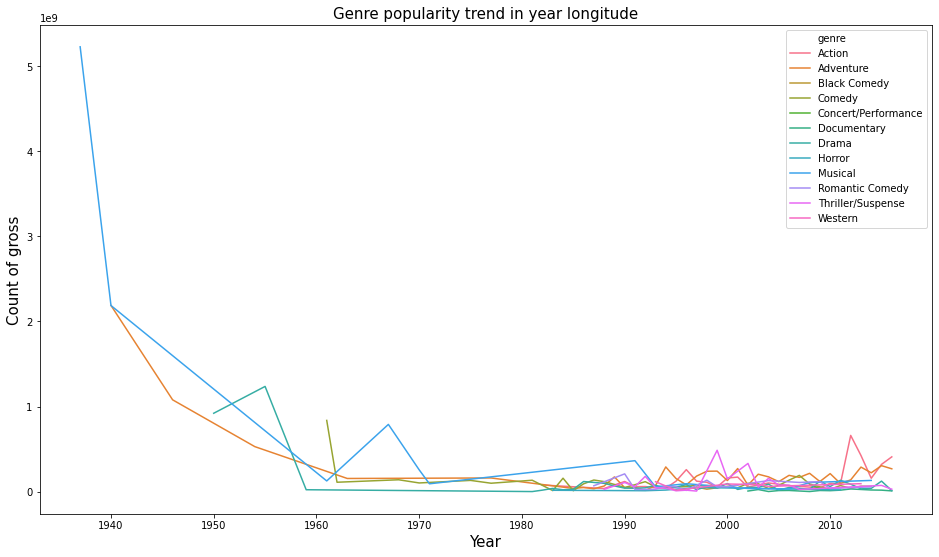

In [17]:
ax=plt.figure(figsize=(16,9))
ax=sns.lineplot(x='release_year', y='inflation_adjusted_gross', hue='genre', data=genre_yearly)
plt.title(f'Genre popularity trend in year longitude', fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Count of gross", fontsize=15)
plt.show()

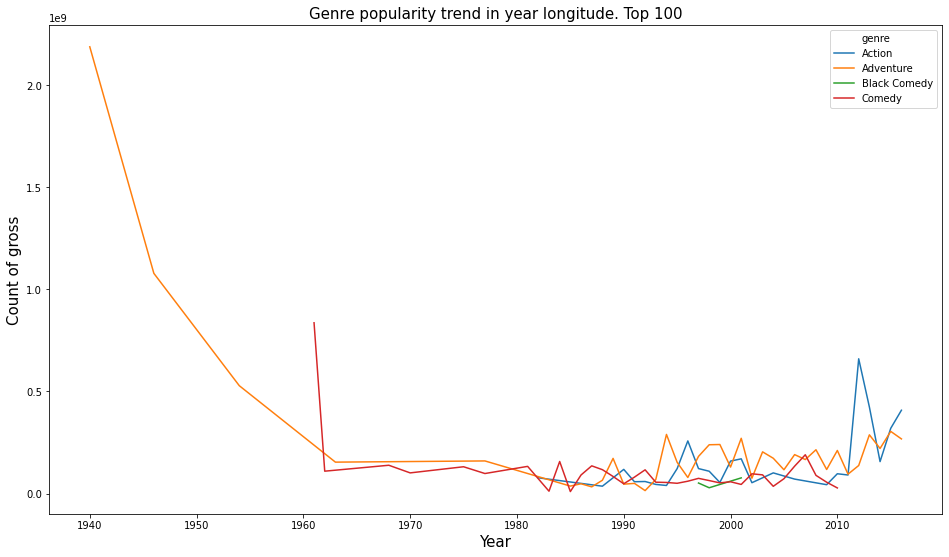

In [18]:
ax=plt.figure(figsize=(16,9))
ax=sns.lineplot(x='release_year', y='inflation_adjusted_gross', hue='genre', data=genre_yearly.head(100))
plt.title(f'Genre popularity trend in year longitude. Top 100', fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Count of gross", fontsize=15)
plt.show()

#### My notice:
An interesting genre "Black Comedy" is not usual for Disney. Let's take a closer look at how films fall into this category.

In [19]:
genre_black_comedy=df[df['genre']=='Black Comedy']
genre_black_comedy

,movie_title,release_date,genre,mpaa_rating,total_gross,inflation_adjusted_gross,release_year,release_month
353,The Royal Tenenbaums,2001-12-14,Black Comedy,R,52353636,76758193,2001,12
261,Grosse Pointe Blank,1997-04-11,Black Comedy,R,28084357,51579764,1997,4
297,Rushmore,1998-12-11,Black Comedy,R,17105219,28392518,1998,12


It turned out that there was nothing out of the ordinary. Two films by Wes Anderson and a film by George Hermitage.

<a name="s_2"></a>
### Are there any peculiarities in monthly trends for movie releases?
[To the table of contents](#table_of_contents)

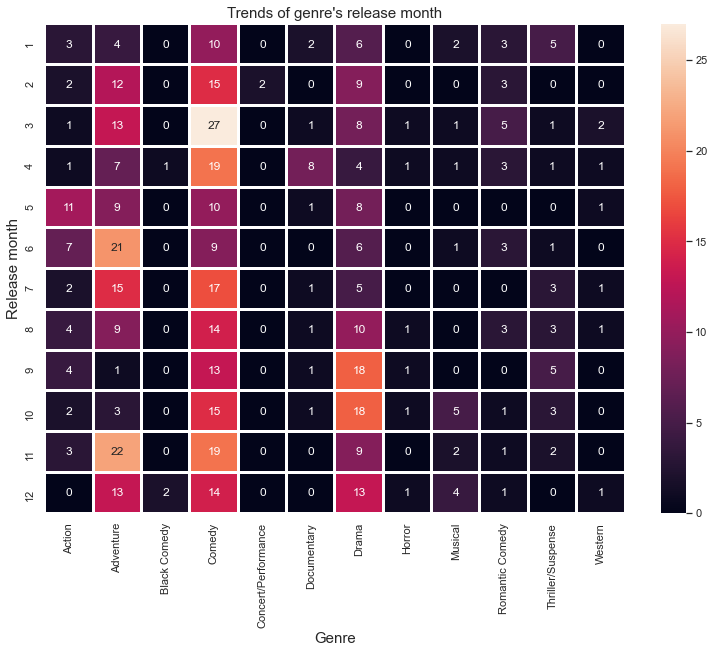

In [20]:
month_trends=df.groupby('genre')['release_month'].value_counts().unstack().fillna(0).T

sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(month_trends, annot=True, linewidths=2)
plt.title(f"Trends of genre's release month", fontsize=15)
plt.xlabel("Genre", fontsize=15)
plt.ylabel("Release month", fontsize=15)
plt.show()


#### My notice:
Everything is as usual. 
* The flagship categories (Adventure, Comedy and Drama) are released all year round. 
* Especially according to the tradition of market demand, the summer months are the largest, especially in July at the height of school and student holidays. 
* It is interesting that dramas are released more in the fall, apparently under the seasonal melancholy. 
* It is strange that romantic comedies do not come out in February on Valentine's Day, but come out in March.

<a name="stage_4"></a>
## 4. Data transformation
[To the table of contents](#table_of_contents)
<p>The line plot supports our belief that some genres are growing faster in popularity than others. For Disney movies, Action and Adventure genres are growing the fastest. Next, we will build a linear regression model to understand the relationship between genre and box office gross. </p>
<p>Since linear regression requires numerical variables and the genre variable is a categorical variable, we'll use a technique called one-hot encoding to convert the categorical variables to numerical. This technique transforms each category value into a new column and assigns a 1 or 0 to the column. </p>
<p>For this dataset, there will be 11 dummy variables, one for each genre except the action genre which we will use as a baseline. For example, if a movie is an adventure movie, like The Lion King, the adventure variable will be 1 and other dummy variables will be 0. Since the action genre is our baseline, if a movie is an action movie, such as The Avengers, all dummy variables will be 0.</p>

In [21]:
# Convert genre variable to dummy variables 
genre_dummies =  pd.get_dummies(data = df['genre'],
                               drop_first = True)

# Inspect genre_dummies
genre_dummies.head()

,Adventure,Black Comedy,Comedy,Concert/Performance,Documentary,Drama,Horror,Musical,Romantic Comedy,Thriller/Suspense,Western
0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0
8,0,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,0


<a name="stage_5"></a>
## 5. The genre effect
[To the table of contents](#table_of_contents)
<p>Now that we have dummy variables, we can build a linear regression model to predict the adjusted gross using these dummy variables.</p>
<p>From the regression model, we can check the effect of each genre by looking at its coefficient given in units of box office gross dollars. We will focus on the impact of action and adventure genres here. (Note that the intercept and the first coefficient values represent the effect of action and adventure genres respectively). We expect that movies like the Lion King or Star Wars would perform better for box office.</p>

In [22]:
# Import LinearRegression
from sklearn.linear_model import LinearRegression

# Build a linear regression model
regr = LinearRegression()

# Fit regr to the dataset
regr = regr.fit(X = genre_dummies, 
                y = df['inflation_adjusted_gross'])

# Get estimated intercept and coefficient values 
action =  regr.intercept_
adventure = regr.coef_[[0]][0]

# Inspect the estimated intercept and coefficient values 
print(f"""
Intercept and Coefficient
-----------------------------
Action: {action} 
Adventure: {adventure}
""")


Intercept and Coefficient
-----------------------------
Action: 102921757.3684209 
Adventure: 87475654.70909853



##### Display top 5 movies of action and adventure genres

In [23]:
# data to be subset
gross_subset = df.loc[ : , ['movie_title', 'inflation_adjusted_gross']]

# conditions
action_condition    = df.loc[ : , 'genre'] == 'Action'
adventure_condition = df.loc[ : , 'genre'] == 'Adventure'

# putting all together
print(f"""
Action
--------------------------------------------------------------------
{gross_subset[action_condition ].sort_values(by = 'inflation_adjusted_gross', ascending = False).head(5)}


Adventure
--------------------------------------------------------------------
{gross_subset[adventure_condition].sort_values(by = 'inflation_adjusted_gross', ascending = False).head(5)}
""")


Action
--------------------------------------------------------------------
                    movie_title  inflation_adjusted_gross
524                The Avengers                 660081224
558     Avengers: Age of Ultron                 459005868
532                  Iron Man 3                 424084233
569  Captain America: Civil War                 408084349
343                Pearl Harbor                 295705112


Adventure
--------------------------------------------------------------------
                              movie_title  inflation_adjusted_gross
1                               Pinocchio                2188229052
3                       Song of the South                1078510579
564  Star Wars Ep. VII: The Force Awakens                 936662225
179                         The Lion King                 761640898
441  Pirates of the Caribbean: Dead Man’…                 544817142



<a name="stage_6"></a>
## 6. Confidence intervals for regression parameters  (i)
[To the table of contents](#table_of_contents)
<p>Next, we will compute 95% confidence intervals for the intercept and coefficients. The 95% confidence intervals for the intercept  <b><i>a</i></b> and coefficient <b><i>b<sub>i</sub></i></b> means that the intervals have a probability of 95% to contain the true value <b><i>a</i></b> and coefficient <b><i>b<sub>i</sub></i></b> respectively. If there is a significant relationship between a given genre and the adjusted gross, the confidence interval of its coefficient should exclude 0.      </p>
<p>We will calculate the confidence intervals using the pairs bootstrap method. </p>

In [24]:
# Create an array of indices to sample from 
inds = np.arange(len(df['genre']))

# Initialize 500 replicate arrays
size = 500
bs_action_reps =  np.empty(size)
bs_adventure_reps =  np.empty(size)

<a name="stage_7"></a>
## 7. Confidence intervals for regression parameters  (ii)
[To the table of contents](#table_of_contents)
<p>After the initialization, we will perform pair bootstrap estimates for the regression parameters. Note that we will draw a sample from a set of (genre, adjusted gross) data where the genre is the original genre variable. We will perform one-hot encoding after that. </p>

In [25]:
# Generate replicates  
for i in range(size):
    
    # Resample the indices 
    bs_inds = np.random.choice(inds, size=len(inds))
        
    # Get the sampled genre and sampled adjusted gross
    bs_genre = df['genre'][bs_inds]
    bs_gross = df['inflation_adjusted_gross'][bs_inds]
    
    # Convert sampled genre to dummy variables
    bs_dummies = pd.get_dummies(bs_genre, drop_first=True)  
    
    # Build and fit a regression model 
    regr = LinearRegression().fit(bs_dummies, bs_gross)
    
    # Compute replicates of estimated intercept and coefficient
    bs_action_reps[i] = regr.intercept_
    bs_adventure_reps[i] = regr.coef_[[0]][0]

<a name="stage_8"></a>
## 8. Confidence intervals for regression parameters (iii)
[To the table of contents](#table_of_contents)
<p>Finally, we compute 95% confidence intervals for the intercept and coefficient and examine if they exclude 0. If one of them (or both) does, then it is unlikely that the value is 0 and we can conclude that there is a significant relationship between that genre and the adjusted gross. </p>

In [26]:
# Compute 95% confidence intervals for intercept and coefficient values
confidence_interval_action = np.percentile(bs_action_reps, [2.5, 97.5])
confidence_interval_adventure = np.percentile(bs_adventure_reps, [2.5, 97.5])

# Inspect the confidence intervals
print(f"""
Confidence Intervals
------------------------------------------
Action: {confidence_interval_action} 
Adventure: {confidence_interval_adventure}
""")


Confidence Intervals
------------------------------------------
Action: [6.97954751e+07 1.39361050e+08] 
Adventure: [3.22987299e+07 1.46724582e+08]



<a name="stage_9"></a>
## 9. Should Disney make more action and adventure movies?
[To the table of contents](#table_of_contents)
<p>The confidence intervals from the bootstrap method for the intercept and coefficient do not contain the value zero, as we have already seen that lower and upper bounds of both confidence intervals are positive. These tell us that it is likely that the adjusted gross is significantly correlated with the action and adventure genres. </p>
<p>From the results of the bootstrap analysis and the trend plot we have done earlier, we could say that Disney movies with plots that fit into the action and adventure genre, according to our data, tend to do better in terms of adjusted gross than other genres. So we could expect more Marvel, Star Wars, and live-action movies in the upcoming years!</p>

In [27]:
# should Disney studios make more action and adventure movies? 
more_action_adventure_movies = True
print('should Disney studios make more action and adventure movies?:', more_action_adventure_movies)

should Disney studios make more action and adventure movies?: True
